In this notebook, I am playing around with the code required to take an image that is saved in the local Postgres database and utilize it in some way. We know that we will be doing some machine learning to locate the dart board, as well as computer vision tasks in order to locate darts, but I mostly concerned with setting up the framework to simply to the following:

<strong>Take an image from the database ---> display it/ read it ---> generate a fake score for it (something we will do for real later) ---> and save it to an appropriate table. Probably a new table I need to create.</strong> 

In [34]:
# Imports
import psycopg2
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
from psycopg2 import sql
from scipy.ndimage import rotate
import cv2
import numpy as np
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import io
import base64
from PIL import Image
import psycopg2
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

### Connect to local postrgres db

In [35]:
# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    cursor = connection.cursor()

    cursor.execute(sql.SQL("SELECT * FROM games LIMIT 5"))  # Replace `your_table_name` with an actual table name
    records = cursor.fetchall()

    print("Records from the table:")
    for record in records:
        print(record)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()

Connection to the database established successfully.
Records from the table:
(1, datetime.datetime(2025, 3, 24, 17, 51, 27, 833086))
(2, datetime.datetime(2025, 3, 24, 17, 54, 6, 198471))
(3, datetime.datetime(2025, 3, 24, 17, 54, 46, 825948))
(4, datetime.datetime(2025, 3, 24, 17, 55, 15, 888245))
(5, datetime.datetime(2025, 3, 24, 17, 59, 22, 982385))


### Displaying an image

Connection to the database established successfully.
Retrieved data type: <class 'str'>


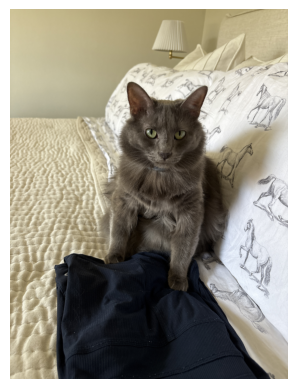

In [36]:
# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

# Connect to the PostgreSQL server
try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    # Create a cursor object
    cursor = connection.cursor()
    
    # Query to retrieve the image data
    cursor.execute("SELECT image_data FROM images WHERE id = %s", (10,))  # Change the 1 to the ID of your image
    image_data = cursor.fetchone()

    if image_data is not None:
        # Print the type of image_data
        print(f"Retrieved data type: {type(image_data[0])}")

        # Decode the Base64 string into bytes
        image_bytes = base64.b64decode(image_data[0])

        # Create an image from the bytes
        image = Image.open(BytesIO(image_bytes))
        
        # Display the image using matplotlib
        image = rotate(image, angle=270, reshape=True)
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()
    else:
        print("No image found with the specified ID.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()


### Sending a processed picture back to the db

Here is where we would theoretically do something to the image. Assuming our image is the dart board with darts thrown at it.. we would do everything required to process that image to get a score out of it.

Since we are not at that point, I will just do a random edit to the image we received, and we can pretend that we did whatever was required to get a score. Therefore, <strong> we will assume here at this point that we are returning a processed dartboard, which can return a score from it. We need to create a new table in our database to do this. </strong>

The below will grab the most recent image captured, display it, process it, and return it to a new table called processed_images

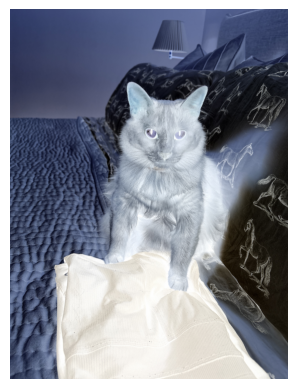

In [37]:
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

def randomDartScores():
    return np.random.randint(1, 21, size=3)  # Random scores between 1 and 20

def processImage(image): # Here we'll turn the image negative
    negative_image = 255 - image
    return negative_image

def process_latest_image():
    # Connect to the PostgreSQL database
    conn = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )
    
    cursor = conn.cursor()

    # Step 1: Retrieve the image with the largest ID
    cursor.execute("SELECT id, player_name, game_id, image_data FROM images ORDER BY id DESC LIMIT 1")
    latest_image_record = cursor.fetchone()

    if latest_image_record:
        image_id, player_name, game_id, image_data = latest_image_record
        
        # Decode the Base64 string into bytes if image_data is a string
        image_bytes = base64.b64decode(image_data)

        # Create an image from the bytes
        image = Image.open(io.BytesIO(image_bytes))
        image = np.array(image)  # Convert the Image object to a numpy array

        # Rotate the image 270 degrees
        image = rotate(image, angle=270, reshape=True)

        # Process the image (turning it negative)
        image = processImage(image)

        # Display the processed image using matplotlib
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()

        # Get dart scores and convert them to regular integers
        dart_scores = randomDartScores()
        dart_1, dart_2, dart_3 = map(int, dart_scores)  # Converts each score to a Python int

        # Store the image back as bytes
        processed_image_data = io.BytesIO()
        plt.imsave(processed_image_data, image)  # Save the processed image to a BytesIO object
        processed_image_data.seek(0)  # Seek to the beginning

        # Insert into processed_images table
        cursor.execute('''
            INSERT INTO processed_images (dart_1, dart_2, dart_3, game_id, player_name, processed_image)
            VALUES (%s, %s, %s, %s, %s, %s)
        ''', (dart_1, dart_2, dart_3, game_id, player_name, processed_image_data.getvalue()))

        # Commit the changes
        conn.commit()

    else:
        print("No images found in the database.")

    # Close the database connection
    conn.close()


# Run the function to process the latest image
process_latest_image()


### Retreiving the processed image from processed_images, and displaying the data it has

Connection to the database established successfully.
Retrieved data type: <class 'memoryview'>


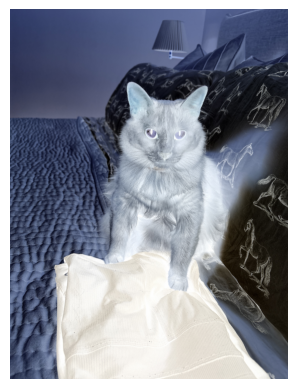

In [38]:
# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

# Connect to the PostgreSQL server
try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    # Create a cursor object
    cursor = connection.cursor()
    
    # Query to retrieve the image data
    cursor.execute("SELECT processed_image FROM processed_images WHERE id = %s", (1,))  # Change the 1 to the ID of your image
    image_data = cursor.fetchone()

    if image_data is not None:
        # Print the type of image_data
        print(f"Retrieved data type: {type(image_data[0])}")

        # Create an image from the bytes (no decoding necessary)
        image = Image.open(BytesIO(image_data[0]))  # Use image_data[0] directly
        
        # Display the image using matplotlib
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()
    else:
        print("No image found with the specified ID.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()


In [39]:
import psycopg2

# Database connection parameters
hostname = 'localhost'
username = 'dart_thrower'
password = 'darts'
database = 'darts'

# Connect to the PostgreSQL server
try:
    connection = psycopg2.connect(
        host=hostname,
        user=username,
        password=password,
        dbname=database
    )

    print("Connection to the database established successfully.")

    # Create a cursor object
    cursor = connection.cursor()
    
    # Query to retrieve all columns for the row where id = 1
    cursor.execute("SELECT * FROM processed_images WHERE id = %s", (1,))
    row = cursor.fetchone()  # Fetch the first row of results

    if row is not None:
        # Print all columns in the retrieved row
        column_names = [desc[0] for desc in cursor.description]
        for column_name, value in zip(column_names, row):
            print(f"{column_name}: {value}")
    else:
        print("No row found with the specified ID.")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the cursor and connection
    if cursor:
        cursor.close()
    if connection:
        connection.close()


Connection to the database established successfully.
id: 1
dart_1: 1
dart_2: 17
dart_3: 1
game_id: 34
player_name: Reed
processed_image: <memory at 0x77e53f852440>


So now, we can read and write images to our database. We will just need to figure out a scoring function, and flesh out the front end. Add in some "cricket" game logic and we are complete. 

### Messing around with a sample photo

In [40]:
#!pip install opencv-python numpy tensorflow

All I did in the below was create a function that will grab template photos from an image of the board for the 20 and the 3. We can can use some geometry to get the rest of the board.

You could also just screenshot the 20 and the 3 from the larger photo.

In [50]:
def create_template(image_path, output_20_path, output_3_path):
    # Load the dartboard image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Define the coordinates for cropping the numbers
    # You may need to adjust these coordinates based on your image
    # Format: (start_x, start_y, width, height)
    coords_20 = (2051,1864,70,70)  # Example coordinates for "20"
    coords_3 = (2066,2635,50,60)   # Example coordinates for "3"

    # Crop the "20" number
    x, y, w, h = coords_20
    template_20 = image[y:y+h, x:x+w]
    cv2.imwrite(output_20_path, template_20)
    print(f"Template for '20' saved to {output_20_path}")

    # Crop the "3" number
    x, y, w, h = coords_3
    template_3 = image[y:y+h, x:x+w]
    cv2.imwrite(output_3_path, template_3)
    print(f"Template for '3' saved to {output_3_path}")

# Only need to do this once to get the intial templates
# create_template(
#     '/home/tars/Projects/Dart-Vision/Sample Images/throw_1_1.JPG',
#     '/home/tars/Projects/Dart-Vision/Templates/20_cropped.png',
#     '/home/tars/Projects/Dart-Vision/Templates/3_cropped.png'
# )


Now, in the below code, we take in the image of our darts that were thrown.. an output path, and our two templates.

The result is a cropped image of the board. 

The next step would be to get this in a workflow such that we are able to pull the most recently captured photo when a user saves a photo from the front end. For now, I am less worried about the logistics of that and more worried about quantifying the board for scoring. 

<strong> One notable shortcoming of this method is that the template for the 20 and the 3 do not currently work for 20's and 3's at different scales. Therefore, if a user zoomed in and took their photo, the board would not be detected correctly. I tested this with the sample photos, and all the photos I took from where I threw the darts worked perfectly fine, despite me not being super careful about where I took the photo from. </strong>

In [52]:
def detect_numbers_and_crop(image_path, output_path, template_20_path, template_3_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load templates for "20" and "3"
    template_20 = cv2.imread(template_20_path, cv2.IMREAD_GRAYSCALE)
    template_3 = cv2.imread(template_3_path, cv2.IMREAD_GRAYSCALE)

    # Perform template matching for 20
    res_20 = cv2.matchTemplate(gray, template_20, cv2.TM_CCOEFF_NORMED)
    threshold_20 = 0.8  # Adjust this threshold as needed
    loc_20 = np.where(res_20 >= threshold_20)

    # Perform template matching for 3
    res_3 = cv2.matchTemplate(gray, template_3, cv2.TM_CCOEFF_NORMED)
    threshold_3 = 0.8  # Adjust this threshold as needed
    loc_3 = np.where(res_3 >= threshold_3)

    # Check if both numbers were found
    if loc_20[0].size == 0 or loc_3[0].size == 0:
        print("Could not find both numbers on the dartboard.")
        return

    # Get the coordinates of the detected numbers
    top_left_20 = (loc_20[1][0], loc_20[0][0])
    top_left_3 = (loc_3[1][0], loc_3[0][0])

    # Calculate the bottom-left corner of 3
    bottom_left_3 = (top_left_3[0], top_left_3[1] + template_3.shape[0])

    # Calculate the top-right corner of 20
    top_right_20 = (top_left_20[0] + template_20.shape[1], top_left_20[1])

    # Calculate the center and radius of the circle
    center_x = (bottom_left_3[0] + top_right_20[0]) // 2
    center_y = (bottom_left_3[1] + top_left_20[1]) // 2
    radius = int(np.linalg.norm(np.array(bottom_left_3) - np.array(top_right_20)) // 2)

    # Calculate the bounding box for cropping
    x1 = center_x - radius
    y1 = center_y - radius
    x2 = center_x + radius
    y2 = center_y + radius

    # Ensure the coordinates are within the image boundaries
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]

    # Save the cropped image
    cv2.imwrite(output_path, cropped_image)
    print(f"Cropped image saved to {output_path}")

detect_numbers_and_crop(
    '/home/tars/Projects/Dart-Vision/Sample Images/throw_4_1.JPG',
    '/home/tars/Projects/Dart-Vision/Sample Images/cropped_dartboard.JPG',
    '/home/tars/Projects/Dart-Vision/Templates/20_cropped.png',  # Path to "20" template
    '/home/tars/Projects/Dart-Vision/Templates/3_cropped.png'    # Path to "3" template
)

Cropped image saved to /home/tars/Projects/Dart-Vision/Sample Images/cropped_dartboard.JPG


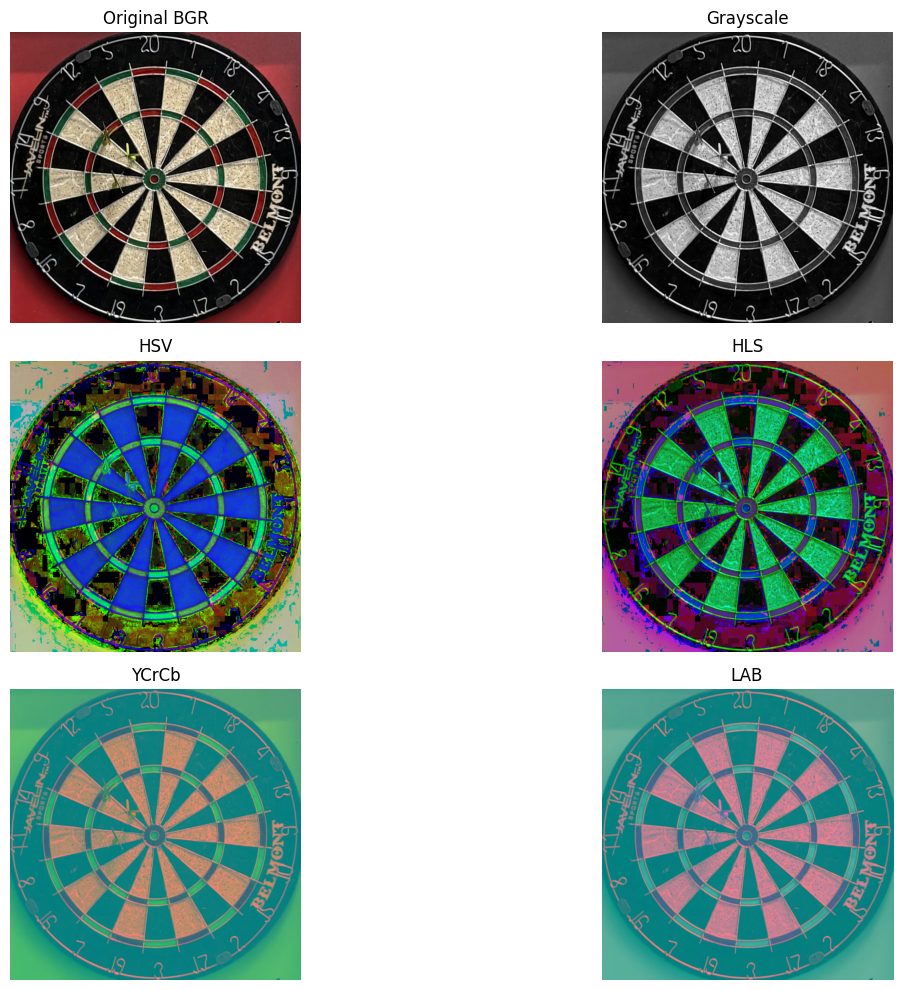

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_color_spaces(image_path):
    # Load the cropped dartboard image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Convert to different color spaces
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hls_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))

    # Display Original BGR Image
    plt.subplot(3, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Original BGR')
    plt.axis('off')

    # Display Grayscale Image
    plt.subplot(3, 2, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # Display HSV Image
    plt.subplot(3, 2, 3)
    plt.imshow(hsv_image)
    plt.title('HSV')
    plt.axis('off')

    # Display HLS Image
    plt.subplot(3, 2, 4)
    plt.imshow(hls_image)
    plt.title('HLS')
    plt.axis('off')

    # Display YCrCb Image
    plt.subplot(3, 2, 5)
    plt.imshow(ycrcb_image)
    plt.title('YCrCb')
    plt.axis('off')

    # Display LAB Image
    plt.subplot(3, 2, 6)
    plt.imshow(lab_image)
    plt.title('LAB')
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
visualize_color_spaces('/home/tars/Projects/Dart-Vision/Sample Images/cropped_dartboard.JPG')
